In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import random
import shutil
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# download the mobilenet model and call the summary function to check out the structure of the model
#mobile = tf.keras.applications.mobilenet.MobileNet()
#mobile.summary()

In [ ]:
os.chdir(r"C:\Users\HR\pycharm\projects\pneumonia-test\Dataset1")

In [ ]:
train_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset1/train'
valid_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset1/valid'
test_path =  r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset2\test\blncd test'
data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

train_batches = data_generator.flow_from_directory(directory=train_path, 
                                                   target_size=(224,224), 
                                                   batch_size=10)

valid_batches = data_generator.flow_from_directory(directory=valid_path,
                                                   target_size=(224,224), 
                                                   batch_size=10)

test_batches = data_generator.flow_from_directory(directory=test_path, 
                                                  target_size=(224,224), 
                                                  batch_size=10, 
                                                  shuffle=False)



In [ ]:
#layers with parameters starting from the output layer
all_parameter_layers = [1,4,5,7,8,10,11,13,14,17,18,20,21,23,24,26,27,29,30,32,33,35,
                   36,38,39,41,42,44,45,47,48,50,51,54,55,57,58,60,61,63,64,67,68,
                   70,71,73,74,76,77,80,81,83,84,86,87]
parameter_layers = []
idx = 0
while idx < len(all_parameter_layers):
    parameter_layers.append(all_parameter_layers[idx])
    idx += 2
parameter_layers.index(74),len(parameter_layers)

In [ ]:
parameter_layers.index(45)

In [ ]:
for n in parameter_layers[24:]:
    mobile = tf.keras.applications.mobilenet.MobileNet()
    #  Build the fine-tuned model
    x = mobile.layers[-6].output
    output = Dense(units=2, activation='softmax')(x)
    model = Model(inputs=mobile.input, outputs=output)
    
    for layer in model.layers [:-n]:
        layer.trainable = False
    
    print(f"training model {n}")
    #  Compile and train the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x=train_batches,
              steps_per_epoch=len(train_batches),
              validation_data=valid_batches,
              validation_steps=len(valid_batches),
              epochs=25,
              verbose=2)

    #  Save your fine-tuned model
    model.save(f'mobilenet-full-{n}.h5')
    print(f"model {n} saved successfully")




# Evaluation

In [ ]:
test_batches.class_indices

In [2]:
os.chdir(r'C:\Users\HR\pycharm\projects\pneumonia-test\mobilenet models')

In [ ]:
df = pd.DataFrame(columns = ["Layers_retrained",
                             "Accuracy", "Precision", "Recall","F1-score",
                             ])
for n in parameter_layers:
    print(f"model {n}")
    new_model = load_model(f'mobilenet-full-{n}.h5')
    predictions = new_model.predict(x=test_batches, steps=len(test_batches), verbose=0)
    y_pred = np.argmax(predictions, axis=-1) #returns the indices of the max value along the rows
    
    def accuracy(true_labels , predicted_labels):
        m = tf.keras.metrics.Accuracy()
        m.update_state(true_labels,predicted_labels )
        return m.result().numpy()
    
    acc = accuracy(true_labels = test_batches.classes,
                      predicted_labels = y_pred)
    print(f'accuracy: {acc}')

    def precision(true_labels , predicted_labels):
        m = tf.keras.metrics.Precision()
        m.update_state(true_labels,predicted_labels )
        return m.result().numpy()
    
    precsn = precision(true_labels = test_batches.classes,
                        predicted_labels = y_pred)
    print(f'precision: {precsn}')

    def recall(true_labels , predicted_labels):
        m = tf.keras.metrics.Recall()
        m.update_state(true_labels,predicted_labels )
        return m.result().numpy()
    
    recll = recall(true_labels = test_batches.classes,
                        predicted_labels = y_pred)
    print(f'recall: {recll}')

    from sklearn.metrics import f1_score
    def f_score(true_labels , predicted_labels):
      return f1_score(true_labels , predicted_labels)

    f1_score = f_score(true_labels = test_batches.classes,
                        predicted_labels = y_pred)
    print(f'f1-score: {f1_score}')
    print()
    df = df.append([{"Layers_retrained" : f"{n}",
            "Accuracy" : acc,
            "Precision": precsn,
           "Recall" : recll,
            "F1-score" :f1_score }],
          ignore_index = True)
df
    

In [ ]:
df.to_excel('Mobilenet_full-dataset.xlsx')

## Visuals

In [26]:
df_full = pd.read_excel('Mobilenet_full-dataset.xlsx')


In [27]:
del(df_full['Unnamed: 0'])

In [28]:
df_full = df_full.set_index('Layers_retrained')
df_full

,Accuracy,Precision,Recall,F1-score
Layers_retrained,,,,
1,0.949367,0.922619,0.981013,0.950920
5,0.968354,0.951219,0.987342,0.968944
8,0.974684,0.980769,0.968354,0.974522
11,0.943038,0.897727,1.000000,0.946108
14,0.974684,0.974684,0.974684,0.974684
18,0.981013,0.975000,0.987342,0.981132
21,0.962025,0.986667,0.936709,0.961039
24,0.939873,0.892655,1.000000,0.943284
27,0.958861,0.923977,1.000000,0.960486


## All metrics

<AxesSubplot:xlabel='Layers_retrained'>

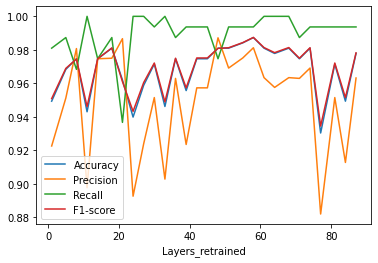

In [29]:
df_full.plot()

## F1-score

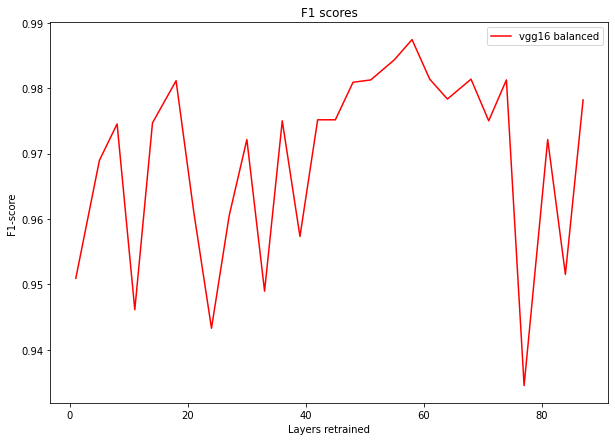

In [30]:
plt.figure(figsize = (10,7))
plt.plot(df_full['F1-score'],color = 'red', label = 'vgg16 balanced')
plt.xlabel('Layers retrained')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1 scores')
plt.show()

## F-score, precision and recall

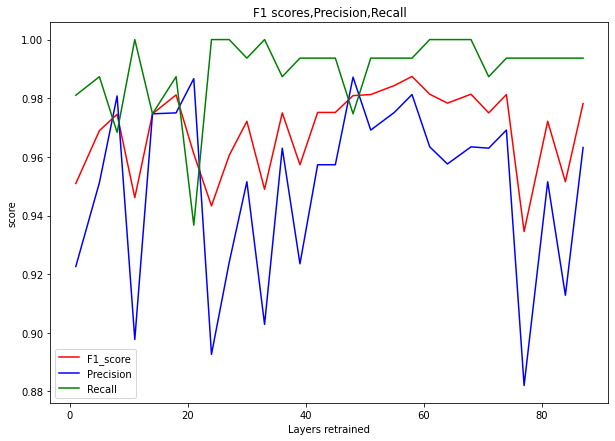

In [31]:
plt.figure(figsize = (10,7))
plt.plot(df_full['F1-score'],color = 'red', label = 'F1_score')
plt.plot(df_full['Precision'],color = 'blue', label = 'Precision')
plt.plot(df_full['Recall'],color = 'green', label = 'Recall')

plt.xlabel('Layers retrained')
plt.ylabel('score')
plt.legend()
plt.title('F1 scores,Precision,Recall')
plt.show()

In [32]:
df_full

,Accuracy,Precision,Recall,F1-score
Layers_retrained,,,,
1,0.949367,0.922619,0.981013,0.950920
5,0.968354,0.951219,0.987342,0.968944
8,0.974684,0.980769,0.968354,0.974522
11,0.943038,0.897727,1.000000,0.946108
14,0.974684,0.974684,0.974684,0.974684
18,0.981013,0.975000,0.987342,0.981132
21,0.962025,0.986667,0.936709,0.961039
24,0.939873,0.892655,1.000000,0.943284
27,0.958861,0.923977,1.000000,0.960486


Precision = tp/(tp + fp)  
Precision = tp/predicted positives  
High precision >> less false positives  

Recall = tp/(tp + fn)  
Recall = tp/ actual positives  
High recall >> less false negatives  

In [23]:
def prepare_image_mobilenet(file):
    #load image from file
    img = load_img(file, target_size=(224, 224))
    # convert the image pixels to a numpy array
    img_arr = img_to_array(img)
    # reshape data for the model
    img_arr = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))
    # same as np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_arr)

In [38]:
normal_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset2\test\blncd test\NORMAL\\'
pneumonia_path = r'C:\Users\HR\pycharm\projects\pneumonia-test\Dataset2\test\blncd test\PNEUMONIA\\'

In [96]:
def predict(no_of_imgs, imgs_path, model_no):
    os.chdir(r'C:\Users\HR\pycharm\projects\pneumonia-test\mobilenet models')
    new_model = load_model(f'mobilenet-full-{model_no}.h5')
    
    print(f"number of test images: {no_of_imgs}")
    preds = []
    for count,file_name in enumerate(os.listdir(imgs_path)):
        if count <= no_of_imgs and count != 0:
            file = imgs_path + file_name
            img = prepare_image_mobilenet(file)
            pred = new_model.predict(img)
            pred = np.argmax(pred, axis=-1) #returns the indices of the max value along the rows
            preds.append(pred[0])
    
    if 'NORMAL' in imgs_path:
        print(f"predictions on Normal images: {preds}")
        wrong_preds = preds.count(1)
        print(f"wrong(ie.false positives): {wrong_preds}")
        correct_preds = no_of_imgs - wrong_preds
        print(f"correct: {correct_preds}")
    else:
        print(f"predictions on pneumonia images: {preds}")
        wrong_preds = preds.count(0)
        print(f"wrong (ie.false negatives): {wrong_preds}")
        correct_preds = no_of_imgs - wrong_preds
        print(f"correct: {correct_preds}")

In [103]:
predict(no_of_imgs=158,
        imgs_path = normal_path,
        model_no = 8)

number of test images: 158
predictions on Normal images: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wrong(ie.false positives): 3
correct: 155


In [104]:
predict(no_of_imgs=158,
        imgs_path = pneumonia_path,
        model_no = 8)

number of test images: 158
predictions on pneumonia images: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]
wrong (ie.false negatives): 5
correct: 153
